In [737]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

In [738]:
df = pd.read_csv('data/Expanded_data_with_more_features.csv')
df = df.drop(columns=['Unnamed: 0'])
df

,Gender,EthnicGroup,ParentEduc,LunchType,TestPrep,ParentMaritalStatus,PracticeSport,IsFirstChild,NrSiblings,TransportMeans,WklyStudyHours,MathScore,ReadingScore,WritingScore
0,female,NaN,bachelor's degree,standard,none,married,regularly,yes,3.0,school_bus,< 5,71,71,74
1,female,group C,some college,standard,NaN,married,sometimes,yes,0.0,NaN,5 - 10,69,90,88
2,female,group B,master's degree,standard,none,single,sometimes,yes,4.0,school_bus,< 5,87,93,91
3,male,group A,associate's degree,free/reduced,none,married,never,no,1.0,NaN,5 - 10,45,56,42
4,male,group C,some college,standard,none,married,sometimes,yes,0.0,school_bus,5 - 10,76,78,75
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30636,female,group D,high school,standard,none,single,sometimes,no,2.0,school_bus,5 - 10,59,61,65
30637,male,group E,high school,standard,none,single,regularly,no,1.0,private,5 - 10,58,53,51
30638,female,NaN,high school,free/reduced,completed,married,sometimes,no,1.0,private,5 - 10,61,70,67
30639,female,group D,associate's degree,standard,completed,married,regularly,no,3.0,school_bus,5 - 10,82,90,93


In [739]:
# Checking for NaN's
print(df.isnull().any())

Gender                 False
EthnicGroup             True
ParentEduc              True
LunchType              False
TestPrep                True
ParentMaritalStatus     True
PracticeSport           True
IsFirstChild            True
NrSiblings              True
TransportMeans          True
WklyStudyHours          True
MathScore              False
ReadingScore           False
WritingScore           False
dtype: bool


In [740]:
# Setting categorical features as numbers and removing NaN's by calculating mean value 
for column in df.columns:
    df[column] = df[column].astype('category').cat.codes
    df[column] = df[column].fillna(df[column].mean())

In [741]:
df.isnull().any()

Gender                 False
EthnicGroup            False
ParentEduc             False
LunchType              False
TestPrep               False
ParentMaritalStatus    False
PracticeSport          False
IsFirstChild           False
NrSiblings             False
TransportMeans         False
WklyStudyHours         False
MathScore              False
ReadingScore           False
WritingScore           False
dtype: bool

Text(0.5, 1.0, 'Korelacja między zmiennymi')

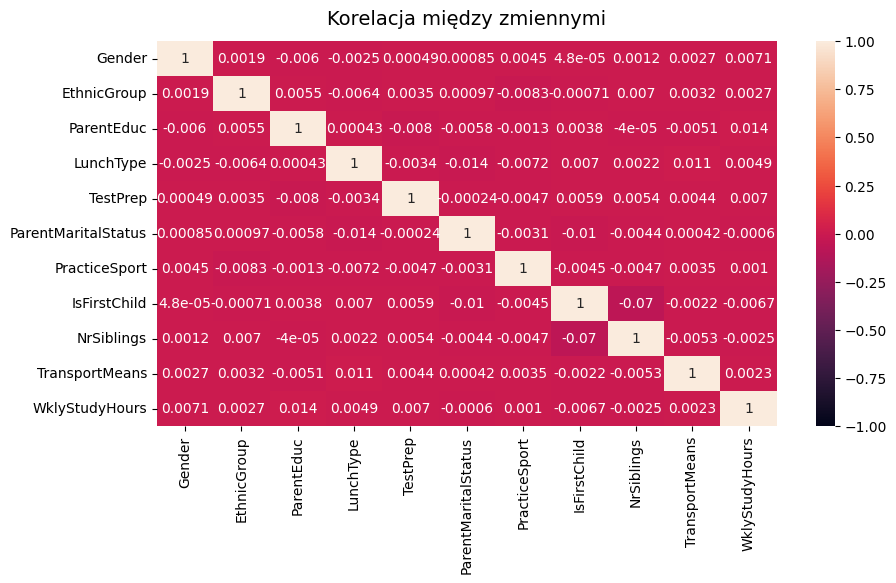

In [742]:
# 
correlation_matrix = df.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).corr()
plt.figure(figsize=(10, 5))
heatmap = sns.heatmap(correlation_matrix, vmin=-1, vmax=1, annot=True)
heatmap.set_title('Korelacja między zmiennymi', fontdict={'fontsize': 14}, pad=12)

In [743]:
num_rows = len(df)
num_rows

30641

In [744]:
input_columns = list(df.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).columns)
input_columns

['Gender',
 'EthnicGroup',
 'ParentEduc',
 'LunchType',
 'TestPrep',
 'ParentMaritalStatus',
 'PracticeSport',
 'IsFirstChild',
 'NrSiblings',
 'TransportMeans',
 'WklyStudyHours']

In [745]:
output_columns = df.columns[-1]
output_columns

'WritingScore'

In [746]:
def dataframe_to_arrays(dataframe: pd.DataFrame) -> list[np.ndarray]:
    # Make a copy of original df
    df1 = dataframe.copy(deep=True)
    # Extract input & outputs as numpy arrays
    input_array = df1.drop(['WritingScore', 'MathScore', 'ReadingScore'], axis=1).values
    target_array = df1[['WritingScore']].values
    return [input_array, target_array]

In [747]:
inputs_array = dataframe_to_arrays(df)[0]
targets_array = dataframe_to_arrays(df)[1]
print(inputs_array.shape, targets_array.shape)
inputs_array, targets_array

(30641, 11) (30641, 1)


(array([[ 0, -1,  1, ...,  3,  1,  1],
        [ 0,  2,  4, ...,  0, -1,  0],
        [ 0,  1,  3, ...,  4,  1,  1],
        ...,
        [ 0, -1,  2, ...,  1,  0,  0],
        [ 0,  3,  0, ...,  3,  1,  0],
        [ 1,  1,  4, ...,  1,  1,  0]], dtype=int8),
 array([[66],
        [80],
        [83],
        ...,
        [59],
        [85],
        [50]], dtype=int8))

In [748]:
inputs = torch.from_numpy(inputs_array).to(torch.float32)
targets = torch.from_numpy(targets_array).to(torch.float32)

In [749]:
inputs.dtype, targets.dtype

(torch.float32, torch.float32)

In [750]:
print((inputs, targets))

(tensor([[ 0., -1.,  1.,  ...,  3.,  1.,  1.],
        [ 0.,  2.,  4.,  ...,  0., -1.,  0.],
        [ 0.,  1.,  3.,  ...,  4.,  1.,  1.],
        ...,
        [ 0., -1.,  2.,  ...,  1.,  0.,  0.],
        [ 0.,  3.,  0.,  ...,  3.,  1.,  0.],
        [ 1.,  1.,  4.,  ...,  1.,  1.,  0.]]), tensor([[66.],
        [80.],
        [83.],
        ...,
        [59.],
        [85.],
        [50.]]))


In [751]:
dataset = TensorDataset(inputs, targets)

In [752]:
val_percent = 0.15
val_size = int(num_rows * val_percent)
print(val_size)
train_size = num_rows - val_size
print(train_size)

# use the random_split function to split dataset into 2 parts of the desired length
train_ds, val_ds = random_split(dataset, [train_size, val_size])

4596
26045


In [753]:
print(len(train_ds), len(val_ds))

26045 4596


In [788]:
batch_size = 64

In [755]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size)

In [756]:
# for xb, yb in train_loader:
#     print(f'inputs: {xb}')
#     print(f'targets: {yb}')

inputs: tensor([[ 0.,  4.,  2.,  0.,  1.,  1.,  1.,  1.,  3.,  0.,  1.],
        [ 0.,  2.,  3.,  0.,  1., -1.,  2.,  1.,  1.,  1.,  0.],
        [ 0.,  4.,  4.,  1.,  1.,  1.,  1.,  1.,  4.,  1.,  1.],
        [ 0.,  3.,  1.,  1.,  0.,  1.,  1.,  1.,  2.,  1.,  2.],
        [ 1.,  2.,  5.,  1.,  1.,  0.,  1.,  1.,  0.,  1.,  1.],
        [ 1.,  4.,  5.,  0.,  1.,  2.,  2.,  0.,  1.,  1.,  1.],
        [ 0.,  2.,  1.,  0.,  0.,  2.,  2.,  0.,  4.,  0.,  1.],
        [ 1.,  3.,  1.,  1.,  0.,  1.,  1.,  1.,  3., -1.,  0.],
        [ 1.,  2.,  2.,  1.,  1.,  0.,  1.,  1.,  0.,  0.,  0.],
        [ 1., -1.,  4.,  1.,  1., -1.,  1.,  0., -1.,  0.,  0.],
        [ 0.,  4.,  1.,  1.,  0.,  2.,  1.,  1.,  1.,  0.,  0.],
        [ 0.,  3.,  4.,  1.,  1.,  2.,  1.,  0.,  3.,  0.,  1.],
        [ 1.,  2.,  5.,  1.,  0.,  1.,  1.,  0.,  2.,  1., -1.],
        [ 1.,  2.,  2.,  1., -1.,  2.,  2.,  1., -1.,  0.,  2.],
        [ 1.,  4.,  2.,  1., -1.,  1.,  1.,  1., -1.,  1.,  0.],
        [ 1.,  3.

#  Create a Linear Regression Model

In [757]:
input_size = len(input_columns)
print(input_size)
output_size = 1
print(output_size)

11
1


In [758]:
class WritingScoreModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    def forward(self, xb):
        out = self.linear(xb)
        return out
    
    def training_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return loss
    
    def validation_step(self, batch):
        inputs, targets = batch
        # Generate predictions
        out = self(inputs)
        # Calculate loss
        loss = F.l1_loss(out, targets)
        return {'val_loss': loss.detach()}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        # Combine losses
        epoch_loss = torch.stack(batch_losses).mean()
        return {'val_loss': epoch_loss.item()}
    
    def epoch_end(self, epoch, result, num_epochs):
        # Print result after 20th epoch
        if (epoch + 1) % 500 == 0 or epoch == num_epochs - 1:
            print(f'Epoch {epoch + 1}, val_loss {result['val_loss']}')

In [759]:
model = WritingScoreModel()

In [760]:
list(model.parameters())

[Parameter containing:
 tensor([[-0.2420,  0.1378,  0.0429, -0.0005, -0.3009,  0.2309,  0.0654, -0.2198,
          -0.2351,  0.1700,  0.2448]], requires_grad=True),
 Parameter containing:
 tensor([0.2255], requires_grad=True)]

In [761]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD) -> list:
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result, epochs)
        history.append(result)
    return history

In [762]:
result = evaluate(model, val_loader)
print(result)

{'val_loss': 60.39482116699219}


In [763]:
# model = WritingScoreModel()

In [764]:
epochs = 1000
lr = 0.001
history1 = fit(epochs, lr, model, train_loader, val_loader)

Epoch 500, val_loss 12.81102466583252
Epoch 1000, val_loss 11.623539924621582


In [765]:
epochs = 1500
lr = 0.05
history2 = fit(epochs, lr, model, train_loader, val_loader)

Epoch 500, val_loss 10.997093200683594
Epoch 1000, val_loss 10.999720573425293
Epoch 1500, val_loss 11.01075553894043


In [766]:
epochs = 2000
lr = 0.1
history3 = fit(epochs, lr, model, train_loader, val_loader)

Epoch 500, val_loss 10.998611450195312
Epoch 1000, val_loss 11.018131256103516
Epoch 1500, val_loss 11.007915496826172
Epoch 2000, val_loss 11.025999069213867


In [784]:
epochs = 2500
lr = 0.4
history4 = fit(epochs, lr, model, train_loader, val_loader)

KeyboardInterrupt: 

In [790]:
epochs = 3000
lr = 0.75
history5 = fit(epochs, lr, model, train_loader, val_loader)

Epoch 500, val_loss 11.07928466796875
Epoch 1000, val_loss 11.056600570678711
Epoch 1500, val_loss 11.018561363220215
Epoch 2000, val_loss 11.114289283752441
Epoch 2500, val_loss 11.011829376220703
Epoch 3000, val_loss 11.0133056640625


In [793]:
val_loss = history5[-1]
val_loss

{'val_loss': 11.0133056640625}

In [794]:
def predict_single(input, target, model):
    inputs = input.unsqueeze(0)
    predictions = model(inputs)
    prediction = predictions[0].detach()
    print(f'Input: {input}')
    print(f'Target: {target}')
    print(f'Prediction: {prediction}')

In [795]:
input, target = val_ds[0]
predict_single(input, target, model)

Input: tensor([ 1.,  4., -1.,  0.,  1.,  2.,  2., -1.,  1.,  1.,  2.])
Target: tensor([51.])
Prediction: tensor([53.2747])


In [796]:
input, target = val_ds[10]
predict_single(input, target, model)

Input: tensor([0., 2., 1., 1., 1., 1., 1., 0., 2., 0., 0.])
Target: tensor([59.])
Prediction: tensor([67.2826])


In [797]:
input,target = val_ds[13]
predict_single(input, target, model)

Input: tensor([1., 2., 4., 1., 1., 1., 2., 0., 3., 1., 1.])
Target: tensor([54.])
Prediction: tensor([56.8286])


In [798]:
input,target = val_ds[54]
predict_single(input, target, model)

Input: tensor([1., 4., 4., 0., 1., 1., 2., 0., 3., 1., 0.])
Target: tensor([73.])
Prediction: tensor([49.6822])


In [799]:
input,target = val_ds[87]
predict_single(input, target, model)

Input: tensor([ 0.,  1.,  2.,  0.,  0.,  0.,  2.,  0., -1.,  0.,  0.])
Target: tensor([82.])
Prediction: tensor([61.6686])
